# Reassigned Spectrogram

In [149]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display
import librosa

## Complex Spectrogram

We start with loading an audio file and calculate the complex valued spectrogram.

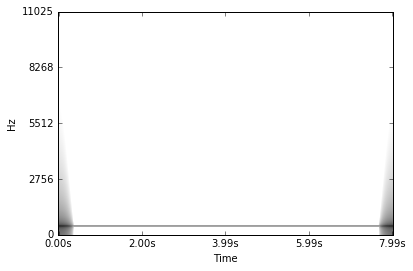

In [150]:
x_fs = 22050
t = np.arange(0, 2, 1/x_fs)
f = 440
x = np.sin(2*np.pi*f*t)
nfft = 4096
hopsize = 128
x_stft = librosa.stft(x, n_fft=nfft, hop_length=hopsize)
x_stft_compressed = librosa.logamplitude(np.abs(x_stft)**2, ref_power=np.max)
librosa.display.specshow(x_stft_compressed,
                         sr=x_fs, x_axis='time', y_axis='linear', cmap=plt.get_cmap('gray_r'))

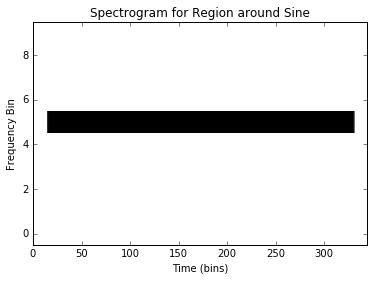

In [151]:
a4_idx = int(np.round((f*nfft)/x_fs))
plt.imshow(np.log(1+10*x_stft_compressed[a4_idx-5:a4_idx+5,:]), cmap=plt.get_cmap('gray_r'),
           origin='lower', interpolation='nearest', aspect='auto')
plt.title('Spectrogram for Region around Sine')
plt.xlabel('Time (bins)')
plt.ylabel('Frequency Bin')

In [152]:
IPython.display.Audio(data=x, rate=x_fs)

## Instantaneous Frequency
### Phase Vocoder

In [153]:
# ToDo

### Instantaneous Frequency Distribution Algorithm (Abe)

We use librosa to get the instantaneous frequencies for each bin.

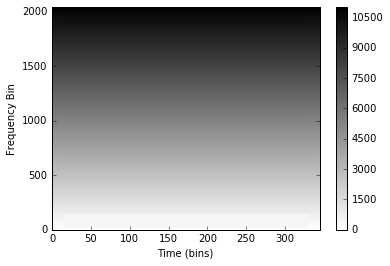

In [154]:
x_ifd, x_stft = librosa.ifgram(x, sr=x_fs, n_fft=nfft, hop_length=hopsize)
plt.imshow(x_ifd, cmap=plt.get_cmap('gray_r'),
           origin='lower', interpolation='nearest', aspect='auto')
plt.colorbar()
plt.xlabel('Time (bins)')
plt.ylabel('Frequency Bin')

As we zoom in to a particular frequency bin (e. g. bin 600), we see that we receive finer frequency estimates.

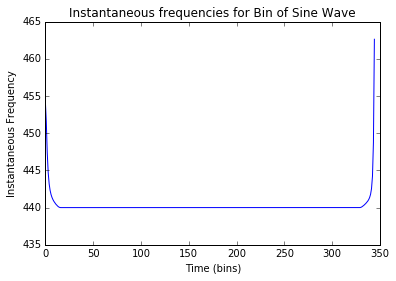

In [155]:
plt.plot(x_ifd[a4_idx, :])
plt.title('Instantaneous frequencies for Bin of Sine Wave')
plt.xlabel('Time (bins)')
plt.ylabel('Instantaneous Frequency')

To do the reassignment, we need to specify a target frequency axis. In our case, we want a logarithmically spaced frequency axis with a resolution of 120 bins per octave (i. e. each bin covers 10 cent).

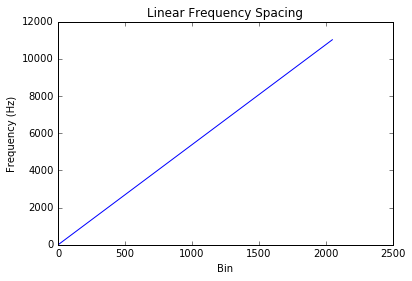

In [156]:
x_freqs_lin = librosa.core.fft_frequencies(sr=x_fs, n_fft=nfft)
plt.plot(x_freqs_lin)
plt.title('Linear Frequency Spacing')
plt.xlabel('Bin')
plt.ylabel('Frequency (Hz)')

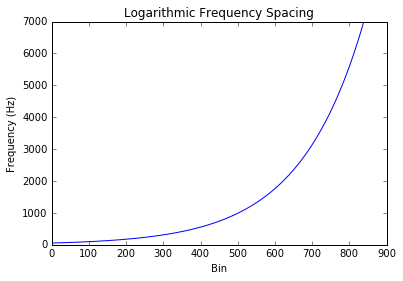

In [157]:
bins_per_octave = 120
min_freq = 55
n_octaves = 7
x_freqs_log = librosa.core.cqt_frequencies(n_octaves*bins_per_octave, min_freq, bins_per_octave=bins_per_octave)
plt.plot(x_freqs_log)
plt.title('Logarithmic Frequency Spacing')
plt.xlabel('Bin')
plt.ylabel('Frequency (Hz)')

## Reassignment

Having the instantaneous frequency, we now simply loop over all bins and sort them into the respective bin in our target representation.

In [158]:
x_stft_abs = np.abs(x_stft)
x_stft_log = np.zeros([len(x_freqs_log), x_stft.shape[1]])
x_start_idx = np.argmin(np.abs(x_freqs_lin-x_freqs_log[0]))
x_end_idx = np.argmin(np.abs(x_freqs_lin-x_freqs_log[-1]))

for (lin_x_idx, lin_y_idx), cur_if in np.ndenumerate(x_ifd[x_start_idx:x_end_idx, :]):
    # get the closest frequency bin for the current IF
    log_x_idx = np.argmin(np.abs(x_freqs_log-cur_if))

    # add the energy to the reassigned stft
    x_stft_log[log_x_idx, lin_y_idx] += x_stft_abs[lin_x_idx, lin_y_idx]

float64


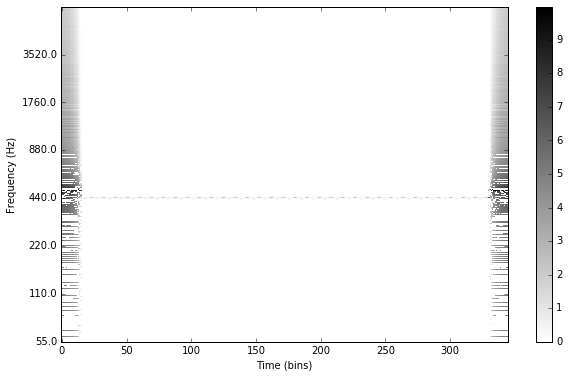

In [159]:
print x_stft_log.dtype
plt.rcParams['figure.figsize'] = 10, 6
plt.imshow(np.log(1+10*x_stft_log), cmap=plt.get_cmap('gray_r'),
           origin='lower', interpolation='nearest', aspect='auto')
plt.colorbar()
# add frequency ticks
ytick_loc = np.arange(0, len(x_freqs_log), bins_per_octave)
plt.yticks(ytick_loc.astype(int), x_freqs_log[ytick_loc.astype(int)])
plt.xlabel('Time (bins)')
plt.ylabel('Frequency (Hz)')

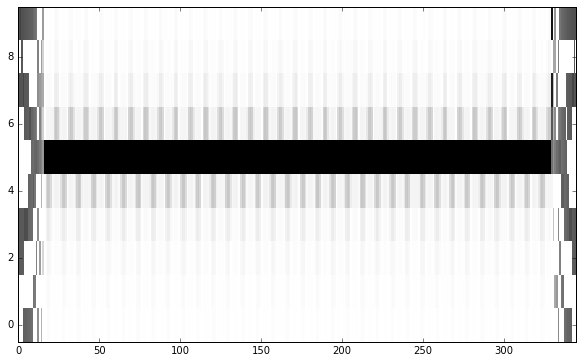

In [160]:
a4_idx = np.argmin(np.abs(x_freqs_log-440))
plt.imshow(np.log(1+10*x_stft_log[a4_idx-5:a4_idx+5,:]), cmap=plt.get_cmap('gray_r'),
           origin='lower', interpolation='nearest', aspect='auto')